<a href="https://colab.research.google.com/github/brunoodon/mvp_sprintII/blob/main/MVP_SprintII(B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics - Sprint II(B)
### Bruno Odon

# Descrição do problema



É um problema de Classificação, onde o objetivo é ter um modelo preditivo que consiga classificar imagens de instrumentos musicais segundo suas catregorias. Serão utilizadas técnicas de Deep Learning para obtenção dos resultados.

## Descrição do dataset:

Este dataset é criado a partir de um banco de imagens de instrumentos musicais à venda.

**Seguem os campos:**

images: o nome do arquivo de imagem

class: o rótulo aplicado a cada imagem

height: altura da imagem

width: largura da imagem

channels: quantidade de canais da imagem

filesize: tamanho do arquivo.





# Preparação dos dados

Primeiramente, vamos instalar e importar as bibliotecas necessárias para o projeto.

In [66]:
!pip install tensorflow
!pip install keras

In [67]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.metrics as skm
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from IPython.display import Image, display
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.keras.preprocessing import image
from IPython.display import Image, display
import os
from sklearn.model_selection import train_test_split
import shutil
import random
import math
import numpy as np
import zipfile
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
import re

Como o volume de dados é grande, o dataset foi armazenado em formato ZIP e, na sequência, descompactado para este diretório.

In [22]:
#apagando todo o conteúdo do diretório (caso exista) onde será baixado o dataset
!rm -rfv datasets/music/*
#criando o diretório, caso seja necessário
!mkdir -pv datasets/music
#baixando os arquivos compactados
!wget 'https://raw.githubusercontent.com/brunoodon/mvp_sprintII/main/music.zip' -P datasets/

removed 'datasets/music/1634109508851_Yamaha SY77 Music Synthesizer for sale.jpg'
removed 'datasets/music/1634109509147_SRX718 BASS BIN PAIR for sale.jpg'
removed 'datasets/music/1634109509344_Piano Malcom Mendis Piano for sale.jpg'
removed 'datasets/music/1634109509573_Yamaha Semi Acoustic Guitars for sale.jpg'
removed 'datasets/music/1634109510073_Yamaha Guitar for sale.jpg'
removed 'datasets/music/1634109510808_Violin for sale.jpg'
removed 'datasets/music/1634109511077_Expnsoin Card Xp 30506080 for sale.jpg'
removed 'datasets/music/1634109511477_+á-╖-â+á-╢-▌+á-╖-Æ+á-╢-⌐+á-╖-è +á-╢-⌐+á-╖-è+ó-Ç-ì+á-╢-++á-╢-╕+á-╖-è for sale.jpg'
removed 'datasets/music/1634109511904_semi acoustic box guitar for sale.jpg'
removed 'datasets/music/1634109512354_32 keys Melodica full set for sale.jpg'
removed 'datasets/music/1634109513457_Guitar wall stand for sale.jpg'
removed 'datasets/music/1634109513875_Fender 41 box guitar for sale.jpg'
removed 'datasets/music/1634109514397_Dilipsons Piano Center for 

In [24]:
#descompactando apenas os arquivos que não tenham "Amp" no nome, para que o modelo não treine "Guitar Amp" como se fosse "Guitar"
import zipfile
dataset = 'datasets/music.zip'
dest = 'datasets/music/'

with zipfile.ZipFile(dataset, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        if "Amp" not in file_info.filename:
            zip_ref.extract(file_info, dest)

In [25]:
#verificando o número de imagens que foram extraídas
path='datasets/music/'
print(f"Temos um total de {len(os.listdir(path))} imagens em nosso dataset")

#exemplos de algumas imagens extraídas
print(f"Primeiras 20 imagens: \n {os.listdir(path)[:20]}")


Temos um total de 2432 imagens em nosso dataset
Primeiras 20 imagens: 
 ['1634112498970_BOYA BYWHM8 Pro Wireless Handheld Microphone for sale.jpg', '1634112358159_Pioneer EFX500 DJ Effects ControllerJAPAN for sale.jpg', '1634118001273_Boya M1DM Dual Mic for sale.jpg', '1634111157863_YAMAHA Piano for sale.jpg', '1634112841166_Dj Light Stand for sale.jpg', '1634112920947_Guitar for sale.jpg', '1634110584381_Electric Guitar for sale.jpg', '1634117638438_Fiber Dholky for sale.jpg', '1634117578620_Cashio organ for sale.jpg', '1634117867993_Pro instrument cable for sale.jpg', '1634109704493_Saxaphone  Soprano for sale.jpg', '1634110189621_YAMAHA FX900 SIMULEFFECT PROCESSOR for sale.jpg', '1634110386536_Professional Studio Recording Microphone Stand Small for sale.jpg', '1634112801953_DJ System for sale.jpg', '1634112953454_Warwick Rockbass Streamer lx 5 Bass Guitar for sale.jpg', '1634110191812_KORG AX1B TONE WORKS Bass for sale.jpg', '1634111526217_Pioneer DJ Setup for sale.jpg', '163411317

Nem todas as imagens serão utilizadas, pois este dataset contém uma quantidade muito grande de categorias. Vamos inserir no dataset 4 classes de instrumentos.

In [56]:
#obtendo a lista de arquivos do diretório onde foram descompactadas as imagens
images = os.listdir(path)
#criando listas vazias para armazenamento dos dados
labels, heights, widths, channels, filesize, files = [], [], [], [], [], []

#como a quantidade de guitarras é muito maior que a de outros instrumentos, foi criado um contador para controlar a quantidade que será inserida no dataset
guitar_count=0
#loop que percorre as imagens do diretório
for fname in images:
    try:
      def file_settings():
          img_shape = mpimg.imread(path+fname).shape
          heights.append(img_shape[0])
          widths.append(img_shape[1])
          channels.append(img_shape[2])
          filesize.append(os.path.getsize(path+fname))
      #será criada uma variável para armazenar o nome do instrumento, baseando-se no nome de cada imagem
      inst_type = str(fname)[14:].replace('.jpg', '').replace('for sale', '')
      #Primeiramente, será criada uma lista de exclusão de nomes de imagens que podem confundir a criação das classes
      if not "Guitar Amp" or not "amp" or not "Speaker" or not "Cube" or not "pedals" or not "Pedals" or not "Pedal" or not "Preamp" or not "Guitar String" or not "Speaker" or not "Bag" or not "Paddle" in inst_type:
        #aplicando as condições para classificação das imagens
        if "Keyboard" in inst_type:
          name = "Keyboard"
          files.append(fname)
          labels.append(name)
          file_settings()
        if "Microphone" in inst_type:
          name = "Microphone"
          files.append(fname)
          labels.append(name)
          file_settings()
        if "Piano" in inst_type:
          name = "Piano"
          files.append(fname)
          labels.append(name)
          file_settings()
        #como dito anteriormente, foi criado um delimitador para que sejam inseridas no máximo 200 imagens de guitarras, deixando assim o dataset balanceado
        if ("Guitar" or "Guitars" or "GUITAR" or "guitar") in inst_type and guitar_count <= 200 and not "Amplifier" in inst_type:
          guitar_count = guitar_count + 1
          name = "Guitar"
          files.append(fname)
          labels.append(name)
          file_settings()
    except:
      print('Não foi possível determinar a classe da imagem')
# Criação do dataset com as imagens coletadas
df = pd.DataFrame({'images': files, 'class': labels, 'height': heights, 'width': widths, 'channels': channels, 'filesize': filesize})
#aqui o dataset está sendo embaralhado e estão sendo exibidas apenas as suas 20 primeiras linhas
df.sample(frac=1).reset_index(drop=True).head(20)



,images,class,height,width,channels,filesize
0,1634112999372_Yamaha Keyboard for sale.jpg,Keyboard,107,142,3,3936
1,1634109745390_Keyboard for sale.jpg,Keyboard,107,142,3,3897
2,1634112350643_Shure SM7B Cardioid Dynamic Voc...,Microphone,107,142,3,3808
3,1634117467880_Semi Accoustic Guitar for sale.jpg,Guitar,107,142,3,3283
4,1634110145306_Keyboard stand df007 soundking f...,Keyboard,107,142,3,3919
5,1634117610864_Maverick Guitar for sale.jpg,Guitar,107,142,3,4330
6,1634112551904_Samson GTrack USB Condenser Mic...,Microphone,107,142,3,2612
7,1634111483723_Guitar for sale.jpg,Guitar,107,142,3,1916
8,1634117637135_XP50 Keyboard for sale.jpg,Keyboard,107,142,3,4664
9,1634110845641_NUX MG30 Versatile Modeler Multi...,Guitar,107,142,3,3336


Guitar        201
Keyboard      113
Microphone     96
Piano          87
Name: class, dtype: int64


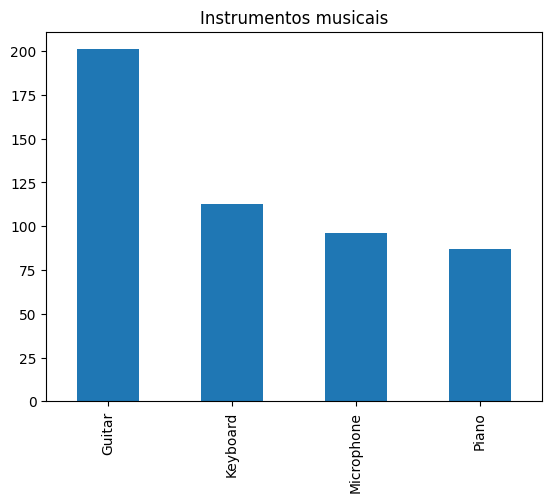

In [57]:
#Visualizando a proporção de imagens por classe
print((df['class']).value_counts())
instruments_count = df['class'].value_counts().plot.bar(title='Instrumentos musicais')

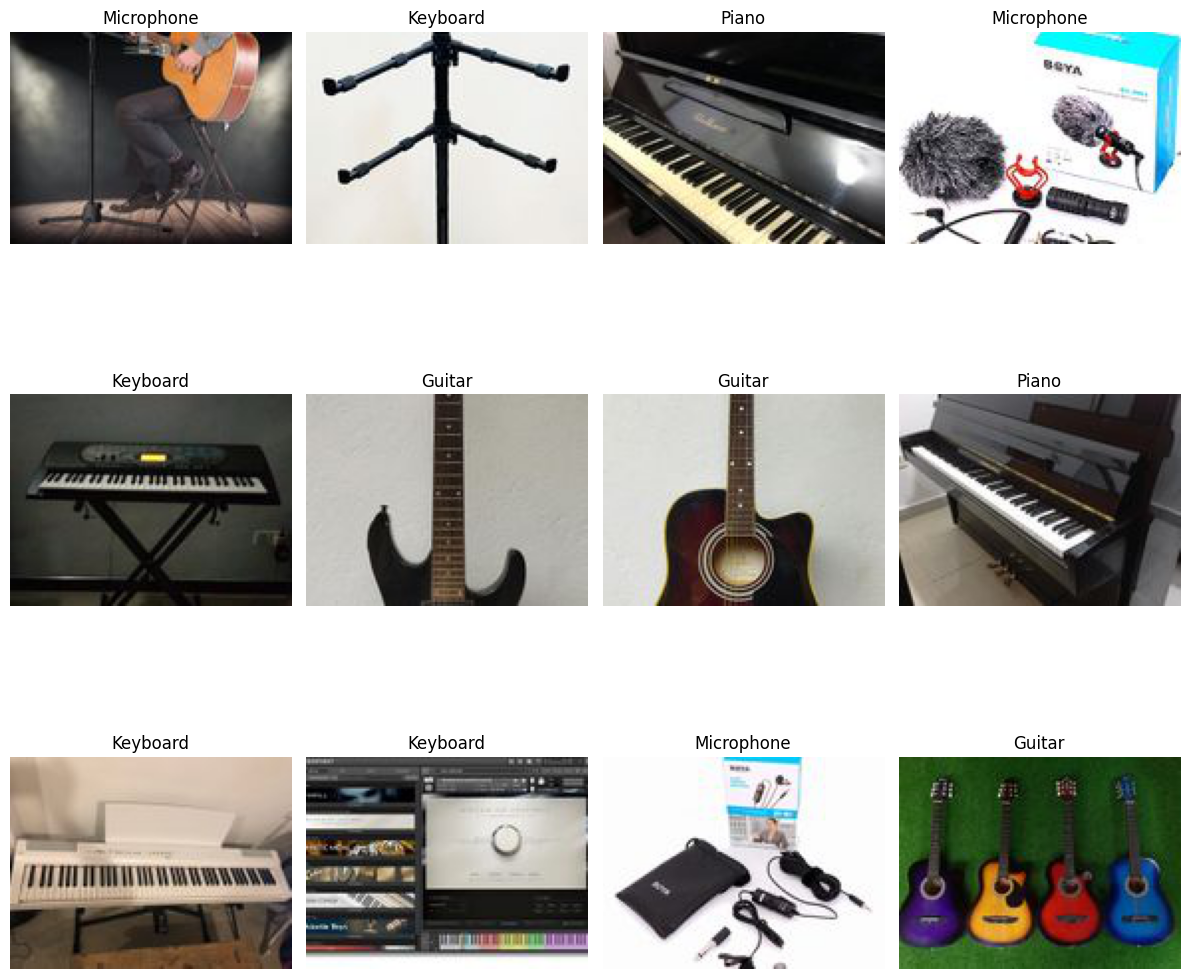

In [58]:
#Exibindo algumas amostras, já com seus respectivos rótulos
import matplotlib.pyplot as plt
from PIL import Image
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)
df_random = df.sample(frac=1).reset_index(drop=True).head(12)
for i, row in df_random.iterrows():
    sp = plt.subplot(3, 4, i + 1)
    sp.axis('Off')
    classe = row['class']
    img_name = row['images']
    img_path = os.path.join(path, img_name)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(classe)
plt.tight_layout()
plt.show()

In [59]:
#Dividindo o dataset em 80% para treino e 20% para teste
train, test = train_test_split(df[['images', 'class', 'height', 'width', 'channels', 'filesize']], test_size=0.2, random_state=42, shuffle=True)
#Exibindo a divisão:
print("CONJUNTO DE TREINO")
display(train)
print("CONJUNTO DE TESTE")
display(test)

CONJUNTO DE TREINO


,images,class,height,width,channels,filesize
56,1634111195681_Bass Guitar for sale.jpg,Guitar,107,142,3,3930
227,1634109517826_Yamaha PSR 433 Keyboard for sale...,Keyboard,107,142,3,4554
280,1634110662533_Eletric Japan Bass Guitar for sa...,Guitar,107,142,3,4896
484,1634113465958_Keyboard for sale.jpg,Keyboard,107,142,3,3730
220,1634110580786_Guitar for sale.jpg,Guitar,107,142,3,3642
...,...,...,...,...,...,...
106,1634113083610_Guitar for sale.jpg,Guitar,107,142,3,6634
270,1634111287516_TWELVE String Triangle Wood Guit...,Guitar,107,142,3,2609
348,1634110350859_Professional Podcasting Condense...,Microphone,107,142,3,3543
435,1634110990416_Casio LK265 Digital Keyboard for...,Keyboard,107,142,3,3806


CONJUNTO DE TESTE


,images,class,height,width,channels,filesize
483,1634117604673_DILIPSONS Piano for sale.jpg,Piano,107,142,3,4068
73,1634117834325_Guitar for sale.jpg,Guitar,107,142,3,5425
231,1634117403717_Casio Electronic Keyboard for sa...,Keyboard,107,142,3,3143
175,1634117998922_IBANEZ Guitar for sale.jpg,Guitar,107,142,3,2577
237,1634109746031_Tik Tok Microphone for sale.jpg,Microphone,107,142,3,4102
...,...,...,...,...,...,...
247,1634117611218_Kawai K1 Midi Keyboard for sale.jpg,Keyboard,107,142,3,3772
383,1634110467733_Lavalier Microphone KM002 for sa...,Microphone,107,142,3,3219
19,1634112136175_Crusader Acoustic Guitar for sal...,Guitar,107,142,3,1966
321,1634110546160_Bluetooth Wireless Microphone fo...,Microphone,107,142,3,3647


Aqui será utilizada a classe ImageDataGenerator, do TensorFlow, para fazer o redimensionamento das imagens. O **data augmentation** aumenta as imagens e é uma técnica muito importante para ajudar no aprendizado.

In [60]:
#esquema de testes de imagens aumentadas (já com o split de validação)
train_datagen=ImageDataGenerator(validation_split=0.2,
                                 rescale = 1.0/255,
                                    rotation_range=40,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
#esquema de testes de imagens aumentadas
test_datagen=ImageDataGenerator(rescale=1./255)

#criando o conjunto de treino com imagens aumentadas
train_generator=train_datagen.flow_from_dataframe(
    train, path,
    target_size=(150,150),
    batch_size=50,
    class_mode='categorical',
    x_col='images',
    y_col='class',
    subset='training' #training set
    )

#criando o conjunto de validação com imagens aumentadas
val_generator=train_datagen.flow_from_dataframe(
    train, path,
    target_size=(150,150),
    batch_size=50,
    class_mode='categorical',
    x_col='images',
    y_col='class',
    subset='validation' #validation set
    )
#criando o conjunto de teste com imagens aumentadas
test_generator=test_datagen.flow_from_dataframe(
    test, path,
    target_size=(150,150),
    batch_size=50,
    class_mode='categorical',
    x_col='images',
    y_col='class')

Found 318 validated image filenames belonging to 4 classes.
Found 79 validated image filenames belonging to 4 classes.
Found 100 validated image filenames belonging to 4 classes.


Aqui vamos exibir um exemplo de uma imagem, em várias posições.


Found 1 validated image filenames belonging to 1 classes.


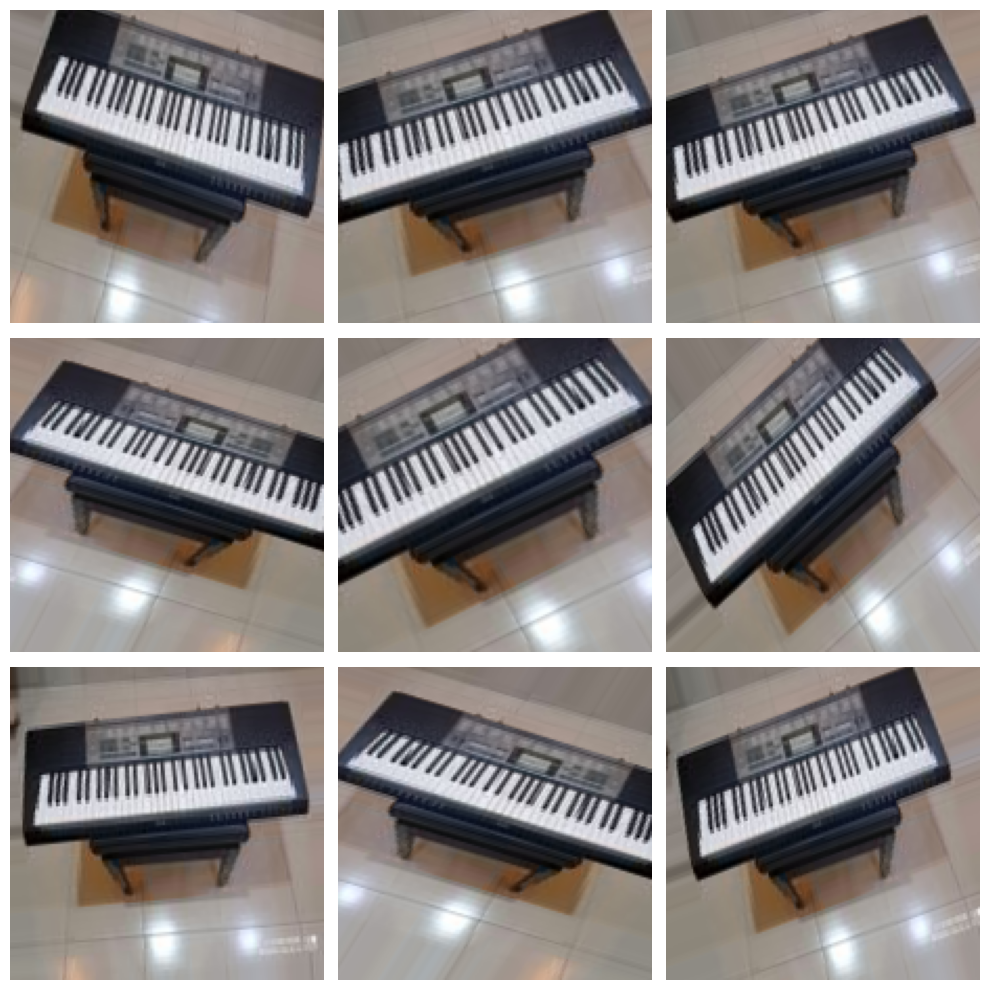

In [61]:
#Coletando um exemplo aleatório do dataset
sample = df.sample(n=1)

#Gerando a imagem
sample_generator = train_datagen.flow_from_dataframe(
    sample,
    path,
    x_col='images',
    y_col='class',
    target_size=(150,150),
    #o tipo de classe é 'categorical', porque temos mais de 2 categorias
    class_mode='categorical'
)

#configurações de exibição da imagem
plt.figure(figsize=(10, 10))
#criando uma lista com 9 posições diferentes para a imagem e exibindo as imagens
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('Off')
        break
plt.tight_layout()
plt.show()

# Modelagem

Nesta etapa do projeto, vamos trabalhar com uma rede neural convolucional (CNN), onde será usada uma camada 2D, com 32 filtros e função de ativação ReLU.

Será usada a biblioteca Keras para criação do modelo.

In [62]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

In [63]:
#exibindo um resumo do modelo
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 128)     

# Treinamento do modelo

Nesta etapa, vamos treinar o modelo de Deep Learning com os seguintes parâmetros:

*optimizer='adam'* : tipo de otimizador utilizado.

*loss='categorical_crossentropy'*: como nosso problema é multiclasse, esta função de perda é a mais adequada.

*metrics=['accuracy']:* métrica a ser utilizada para a avaliação da eficiência do modelo.



In [64]:
#compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy'])

Iniciando o processo de treinamento com o *fit()* , usando o núme3ro de épocas definidas.

Cada época siginfica uma vez onde todo o modelo de treino será percorrido. A tendência é a acurácia ir aumentando a cada rodada.

Foram escolhidas 30 épocas para que o modelo pudesse chegar a um índice alto de acurácia, pois temos o caso da distinção entre 'Piano' e 'Keyboard', que são anatomicamente parecidos.

In [65]:
epochs = 30
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/30
7/7 [==============================] - 25s 3s/step - loss: 1.7991 - accuracy: 0.2956 - val_loss: 1.2770 - val_accuracy: 0.4937
Epoch 2/30
7/7 [==============================] - 23s 4s/step - loss: 1.3063 - accuracy: 0.3962 - val_loss: 1.1443 - val_accuracy: 0.5443
Epoch 3/30
7/7 [==============================] - 20s 3s/step - loss: 1.2001 - accuracy: 0.4623 - val_loss: 1.1173 - val_accuracy: 0.5063
Epoch 4/30
7/7 [==============================] - 21s 3s/step - loss: 1.1412 - accuracy: 0.4874 - val_loss: 1.0536 - val_accuracy: 0.5316
Epoch 5/30
7/7 [==============================] - 21s 3s/step - loss: 1.0571 - accuracy: 0.5692 - val_loss: 1.0115 - val_accuracy: 0.5823
Epoch 6/30
7/7 [==============================] - 21s 3s/step - loss: 1.0184 - accuracy: 0.5849 - val_loss: 1.0524 - val_accuracy: 0.5570
Epoch 7/30
7/7 [==============================] - 20s 3s/step - loss: 1.0872 - accuracy: 0.5157 - val_loss: 1.1009 - val_accuracy: 0.5063
Epoch 8/30
7/7 [==================

# Avaliação de Resultados
##Testando o modelo

Nesta etapa, vamos executar o modelo treinado no **conjunto de teste**, de forma a tentar realizar as predições de classe para cada imagem do dataset.

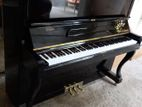

1/1 [==============================] - 0s 157ms/step
True Label: Piano
Prediction: Piano
Probability: 0.7637399




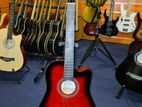

1/1 [==============================] - 0s 48ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.9157935




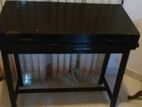

1/1 [==============================] - 0s 68ms/step
True Label: Keyboard
Prediction: Piano
Probability: 0.6731056




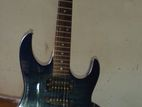

1/1 [==============================] - 0s 68ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.8954175




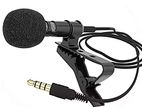

1/1 [==============================] - 0s 101ms/step
True Label: Microphone
Prediction: Microphone
Probability: 0.8883385




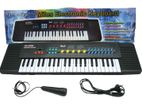

1/1 [==============================] - 0s 119ms/step
True Label: Piano
Prediction: Keyboard
Probability: 0.96239907




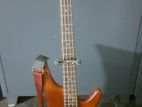

1/1 [==============================] - 0s 179ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.9749025




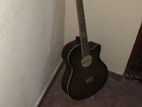

1/1 [==============================] - 0s 172ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.921107




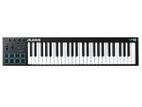

1/1 [==============================] - 0s 141ms/step
True Label: Piano
Prediction: Keyboard
Probability: 0.9849867




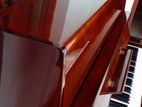

1/1 [==============================] - 0s 95ms/step
True Label: Piano
Prediction: Piano
Probability: 0.5642419




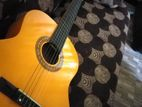

1/1 [==============================] - 0s 218ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.99831414




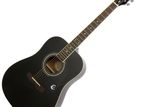

1/1 [==============================] - 0s 147ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.95633584




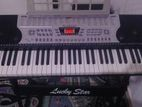

1/1 [==============================] - 0s 118ms/step
True Label: Keyboard
Prediction: Keyboard
Probability: 0.84064025




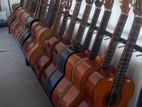

1/1 [==============================] - 0s 60ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.6181704




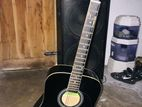

1/1 [==============================] - 0s 78ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.6902509




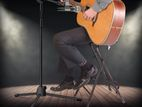

1/1 [==============================] - 0s 87ms/step
True Label: Microphone
Prediction: Guitar
Probability: 0.5639286




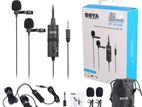

1/1 [==============================] - 0s 54ms/step
True Label: Microphone
Prediction: Guitar
Probability: 0.5196148




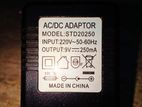

1/1 [==============================] - 0s 93ms/step
True Label: Keyboard
Prediction: Keyboard
Probability: 0.51496214




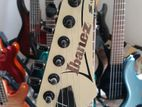

1/1 [==============================] - 0s 60ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.8047432




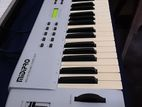

1/1 [==============================] - 0s 151ms/step
True Label: Keyboard
Prediction: Keyboard
Probability: 0.49251425




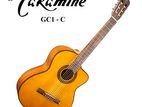

1/1 [==============================] - 0s 81ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.99999976




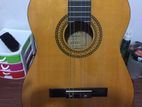

1/1 [==============================] - 0s 69ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.85224473




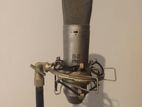

1/1 [==============================] - 0s 55ms/step
True Label: Microphone
Prediction: Guitar
Probability: 0.9394072




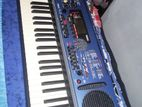

1/1 [==============================] - 0s 66ms/step
True Label: Keyboard
Prediction: Keyboard
Probability: 0.88178253




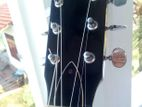

1/1 [==============================] - 0s 72ms/step
True Label: Guitar
Prediction: Microphone
Probability: 0.89839983




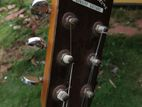

1/1 [==============================] - 0s 61ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.7241618




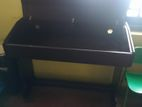

1/1 [==============================] - 0s 69ms/step
True Label: Keyboard
Prediction: Piano
Probability: 0.7901924




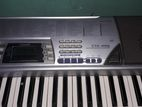

1/1 [==============================] - 0s 64ms/step
True Label: Keyboard
Prediction: Keyboard
Probability: 0.6045501




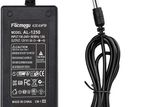

1/1 [==============================] - 0s 83ms/step
True Label: Keyboard
Prediction: Guitar
Probability: 0.5208564




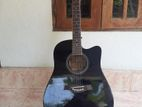

1/1 [==============================] - 0s 86ms/step
True Label: Guitar
Prediction: Microphone
Probability: 0.61746776




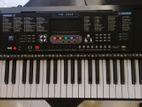

1/1 [==============================] - 0s 57ms/step
True Label: Keyboard
Prediction: Keyboard
Probability: 0.55924517




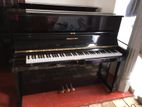

1/1 [==============================] - 0s 79ms/step
True Label: Piano
Prediction: Piano
Probability: 0.9421736




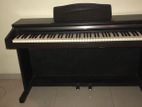

1/1 [==============================] - 0s 71ms/step
True Label: Piano
Prediction: Piano
Probability: 0.78207487




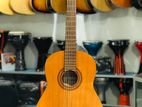

1/1 [==============================] - 0s 71ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.9999914




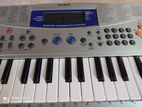

1/1 [==============================] - 0s 60ms/step
True Label: Piano
Prediction: Microphone
Probability: 0.6153199




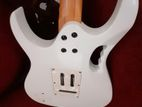

1/1 [==============================] - 0s 83ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.99108547




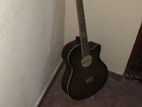

1/1 [==============================] - 0s 63ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.921107




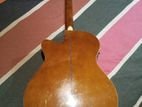

1/1 [==============================] - 0s 64ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.72687274




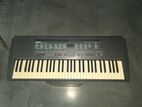

1/1 [==============================] - 0s 50ms/step
True Label: Keyboard
Prediction: Keyboard
Probability: 0.9294834




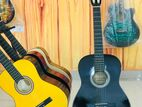

1/1 [==============================] - 0s 74ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.9485233




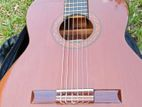

1/1 [==============================] - 0s 72ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.6347161




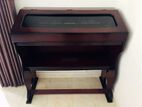

1/1 [==============================] - 0s 60ms/step
True Label: Keyboard
Prediction: Piano
Probability: 0.96013004




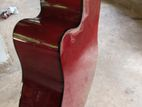

1/1 [==============================] - 0s 52ms/step
True Label: Guitar
Prediction: Piano
Probability: 0.5337495




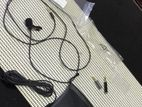

1/1 [==============================] - 0s 57ms/step
True Label: Microphone
Prediction: Keyboard
Probability: 0.6040605




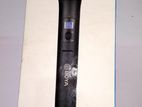

1/1 [==============================] - 0s 93ms/step
True Label: Microphone
Prediction: Guitar
Probability: 0.51508296




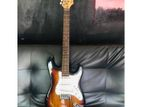

1/1 [==============================] - 0s 68ms/step
True Label: Guitar
Prediction: Piano
Probability: 0.6400575




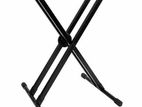

1/1 [==============================] - 0s 60ms/step
True Label: Keyboard
Prediction: Keyboard
Probability: 0.5572016




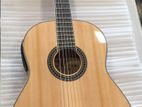

1/1 [==============================] - 0s 62ms/step
True Label: Guitar
Prediction: Guitar
Probability: 0.9909422




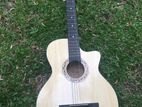

1/1 [==============================] - 0s 70ms/step
True Label: Guitar
Prediction: Keyboard
Probability: 0.7046582




In [68]:
#contador de imagens a serem testadas
count = 0
#nomes das classes existentes
class_names = ['Guitar', 'Keyboard', 'Microphone', 'Piano']
#listas zeradas de predições e de rótulos preditos (y_pred) e verdadeiros (y_true)
y_pred = []
y_true = []
#campos do dataset
column_names=['images', 'class', 'height', 'width', 'channels', 'filesize']
#definição do dataset a ser utilizado
df_test_gen = pd.DataFrame(test, columns=column_names)
for i, row in df_test_gen.iterrows():
    count += 1

    if count == 50:
        break
    else:
        images = row['images']
        labels = row['class']
        y_true.append(labels)
        img_path = os.path.join(path, images)
        img = image.load_img(img_path, target_size=(150, 150))
        display(Image(filename=img_path, width=300))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x.astype('float32') / 255.0
        prediction = model.predict(x)
        predicted_class = np.argmax(prediction[0])
        probability = prediction[0][predicted_class]
        y_pred.append(class_names[predicted_class])
        print("True Label:", labels)
        print("Prediction:", class_names[predicted_class])
        print("Probability:", probability)
        print("\n")



## Matriz de Confusão
Uma das ferramentas mais interessantes para avaliação de resultados de predições é a **Matriz de Confusão**. Ela exibe 2 eixos (X e Y), onde um é o Rótulo real e o outro é a Classificação predita. Desta forma, é possível avaliar se o modelo teve mais acertos do que erros nas predições e se não houve 'underfitting' (onde o modelo não aprendeu bem sobre os dados do conjunto de treino) ou 'overfitting' (onde o modelo se ajusta em excesso aos dados do conjunto de treino).

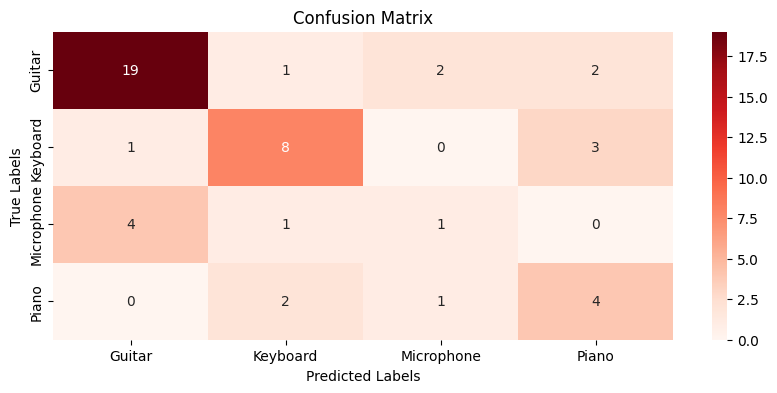

In [69]:
#imprimindo a matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Criando a matrix de confusão
cm = confusion_matrix(y_true, y_pred, labels=class_names)

# Exiba a matriz de confusão usando um heatmap, utilizando o cmap de cores vermelhas
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#Conclusão

Observando tanto a matriz de confusão quanto as amostras preditas do conjunto de teste, observamos não houve overfitting e nem underfitting e que o modelo conseguiu aprendeu bem as imagens da classe Guitar (errando apenas 5 predições, de 24) e também aprendeu bem sobre a classe Keyboard, acertando 8 e errando 4, sendo 2 desses erros a confusão com Piano (que é anatomizamente bem parecido).

Já a classe "Microphone" teve a maioria de suas amostras confundidas com outras classes. Talvez fosse preciso adicionar amostras de melhor qualidade desta classe no conjunto de treino.